In [ ]:
%pip install spacy
%pip install textblob
%pip install spacytextblob
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora
%pip install ipywidgets

## import packages

In [2]:
import os
import glob
import spacy
from textblob import TextBlob
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
import matplotlib.pyplot as plt
import math
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity


# Load the English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [204]:
def parse_xml_to_dataframe(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Extracting play title
    play_title = root.find('TITLE').text

    # Extracting speaker and speech
    data = []
    for speech in root.iter('SPEECH'):
        speaker = speech.find('SPEAKER').text
        lines = [line.text for line in speech.findall('LINE') if line.text]
        speech_text = ' '.join(lines)
        data.append({'title':play_title,'speaker': speaker, 'speech': speech_text})

    # Creating DataFrame
    df = pd.DataFrame(data, columns=['title','speaker', 'speech'])
    return df


In [64]:
# Get all XML files in the zip folder
zip_file_path = 'data/corpora/shaks200.zip'
zip_file_name = os.path.basename(zip_file_path)
zip_file_name_no_ext = os.path.splitext(zip_file_name)[0]
zip_file_dir = os.path.dirname(zip_file_path)
zip_file_extracted_dir = os.path.join(zip_file_dir, zip_file_name_no_ext)
zip_file_extracted_dir = Path(zip_file_extracted_dir)

# Extract the zip file if it hasn't been extracted already
if not zip_file_extracted_dir.exists():
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(zip_file_extracted_dir)

# Get all XML files in the extracted folder
xml_files = glob.glob(f'{zip_file_extracted_dir}/**/*.xml', recursive=True)
logging.info(f"Found {len(xml_files)} XML files")
# Parse each XML file into a DataFrame
dfs = []
for xml_file in tqdm(xml_files, desc="Parsing XML files"):
    df = parse_xml_to_dataframe(xml_file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
df


Parsing XML files:   0%|          | 0/37 [00:00<?, ?it/s]

title          speaker  \
0       The Second Part of Henry the Sixth          SUFFOLK   
1       The Second Part of Henry the Sixth    KING HENRY VI   
2       The Second Part of Henry the Sixth   QUEEN MARGARET   
3       The Second Part of Henry the Sixth    KING HENRY VI   
4       The Second Part of Henry the Sixth              ALL   
...                                    ...              ...   
31023  The Tragedy of Antony and Cleopatra      First Guard   
31024  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   
31025  The Tragedy of Antony and Cleopatra        DOLABELLA   
31026  The Tragedy of Antony and Cleopatra      First Guard   
31027  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   

                                                  speech  
0      As by your high imperial majesty I had in char...  
1      Suffolk, arise. Welcome, Queen Margaret: I can...  
2      Great King of England and my gracious lord, Th...  
3      Her sight did ravish; but her grace in speech,...  
4                                             happiness!  
...                                                  ...  
31023  O Caesar, This Charmian lived but now; she sto...  
31024  O noble weakness! If they had swallow'd poison...  
31025  Here, on her breast, There is a vent of blood ...  
31026  This is an aspic's trail: and these fig-leaves...  
31027  Most probable That so she died; for her physic...  

[31028 rows x 3 columns]

In [25]:
# For testing purposes, use a subset of the data
df = df.head(10)

In [65]:
# process each speech using spaCy
df['speech_processed'] = df['speech'].apply(lambda x: nlp(x))
df.head() # Displaying the first few rows of the DataFrame

title         speaker  \
0  The Second Part of Henry the Sixth         SUFFOLK   
1  The Second Part of Henry the Sixth   KING HENRY VI   
2  The Second Part of Henry the Sixth  QUEEN MARGARET   
3  The Second Part of Henry the Sixth   KING HENRY VI   
4  The Second Part of Henry the Sixth             ALL   

                                              speech  \
0  As by your high imperial majesty I had in char...   
1  Suffolk, arise. Welcome, Queen Margaret: I can...   
2  Great King of England and my gracious lord, Th...   
3  Her sight did ravish; but her grace in speech,...   
4                                         happiness!   

                                    speech_processed  
0  (As, by, your, high, imperial, majesty, I, had...  
1  (Suffolk, ,, arise, ., Welcome, ,, Queen, Marg...  
2  (Great, King, of, England, and, my, gracious, ...  
3  (Her, sight, did, ravish, ;, but, her, grace, ...  
4                                     (happiness, !)

In [187]:

def process_speeches(input_df, senticnet_path,):
    # Caricare SenticNet data
    senticnet_data = pd.read_csv(senticnet_path, delimiter="\t")
    categories = ['INTROSPECTION', 'TEMPER', 'ATTITUDE', 'SENSITIVITY']

    # Preparare il DataFrame per i risultati
    results = []
    

    for _, row in tqdm(input_df.iterrows(), total=input_df.shape[0]):
        speech_processed = row['speech_processed']
        speaker = row['speaker']
        speech = row['speech']
        title = row['title']

        # Accumulators for each category and emotion
        accumulators = {}
        polaritylist = []
        for sent in speech_processed.sents:
            for token in sent:
                token_text = token.text.lower()
                matching_row = senticnet_data[senticnet_data['CONCEPT'] == token_text]
                logging.debug(f"Token: {token_text}, matching row: {matching_row}")

                if not matching_row.empty:
                    # Find max and min categories
                    max_category = matching_row[categories].astype(float).idxmax(axis=1).iloc[0]
                    min_category = matching_row[categories].astype(float).idxmin(axis=1).iloc[0]
                    
                    primary_emotion = matching_row['PRIMARY EMOTION'].iloc[0]
                    secondary_emotion = matching_row['SECONDAY EMOTION'].iloc[0]
    
                    if pd.isna(primary_emotion):
                        max_emotion = max_category
                    else:
                        max_emotion = f"{max_category}{matching_row['PRIMARY EMOTION'].iloc[0]}"
    
                    if pd.isna(secondary_emotion):
                        min_emotion = min_category
                    else:
                        min_emotion = f"{min_category}{matching_row['SECONDAY EMOTION'].iloc[0]}"

                    if max_emotion not in accumulators:
                        accumulators[max_emotion] = []
                    if min_emotion not in accumulators:
                        accumulators[min_emotion] = []

                    accumulators[max_emotion].append(matching_row[max_category].iloc[0])
                    if max_emotion != min_emotion:
                        accumulators[min_emotion].append(matching_row[min_category].iloc[0])
                        
                    polarity = matching_row["POLARITY INTENSITY"].astype(float).iloc[0]
                    logging.debug(f"Token: {token_text}, polarity: {polarity}")
                    polaritylist.append(polarity)
                else:
                    logging.debug(f"Token: {token_text}, no matching row found")
                    
                   

        # Calculate averages for each emotion category
        emotion_avg = {emotion: sum(values) / len(values) if values else 0 for emotion, values in accumulators.items()}
        
        # Calculate average polarity for the speech
        polarity_avg = {"POLARITY": sum(polaritylist) / len(polaritylist) if polaritylist else 0}
        
        
        
        result_row = {'title':title,"speaker": speaker, "speech": speech, **emotion_avg, **polarity_avg}
        results.append(result_row)
    # drop columns with all 0
    results = pd.DataFrame(results).fillna(0)
    results = results.loc[:, (results != 0).any(axis=0)]
    
    # Verify that directory exists otherwise create it
    Path("results/speeches_processed.csv").parent.mkdir(parents=True, exist_ok=True)
    results.to_csv('results/speeches_processed.csv', index=False)
    return results
   

In [67]:
processed_df = process_speeches(df, 'data/senticnet/senticnet.tsv')
processed_df

  0%|          | 0/31028 [00:00<?, ?it/s]

title          speaker  \
0       The Second Part of Henry the Sixth          SUFFOLK   
1       The Second Part of Henry the Sixth    KING HENRY VI   
2       The Second Part of Henry the Sixth   QUEEN MARGARET   
3       The Second Part of Henry the Sixth    KING HENRY VI   
4       The Second Part of Henry the Sixth              ALL   
...                                    ...              ...   
31023  The Tragedy of Antony and Cleopatra      First Guard   
31024  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   
31025  The Tragedy of Antony and Cleopatra        DOLABELLA   
31026  The Tragedy of Antony and Cleopatra      First Guard   
31027  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   

                                                  speech  TEMPER#serenity  \
0      As by your high imperial majesty I had in char...          0.26750   
1      Suffolk, arise. Welcome, Queen Margaret: I can...          0.25000   
2      Great King of England and my gracious lord, Th...          0.25725   
3      Her sight did ravish; but her grace in speech,...          0.00000   
4                                             happiness!          0.00000   
...                                                  ...              ...   
31023  O Caesar, This Charmian lived but now; she sto...          0.19600   
31024  O noble weakness! If they had swallow'd poison...          0.26000   
31025  Here, on her breast, There is a vent of blood ...          0.00000   
31026  This is an aspic's trail: and these fig-leaves...          0.00000   
31027  Most probable That so she died; for her physic...          0.27720   

       INTROSPECTION#acceptance  ATTITUDE#delight  INTROSPECTION  \
0                        0.0000          0.934000      -0.027417   
1                        0.0000          0.000000       0.000000   
2                        0.0000          0.914500       0.000000   
3                        0.0000          0.931000      -0.266667   
4                        0.0000          0.000000       0.000000   
...                         ...               ...            ...   
31023                    0.0000          0.999000      -0.514667   
31024                    0.0000          0.933000      -0.415500   
31025                    0.0000          0.000000       0.000000   
31026                    0.0000          0.000000       0.000000   
31027                   -0.1318          0.992667      -0.140167   

       INTROSPECTION#ecstasy  INTROSPECTION#terror  SENSITIVITY#loathing  ...  \
0                   0.913000              0.000000                -0.965  ...   
1                   0.899000              0.000000                 0.000  ...   
2                   0.944200              0.000000                 0.000  ...   
3                   0.927333              0.000000                 0.000  ...   
4                   0.000000              0.000000                 0.000  ...   
...                      ...                   ...                   ...  ...   
31023               0.934333              0.000000                -0.849  ...   
31024               0.858000              0.000000                 0.000  ...   
31025               0.000000              0.000000                 0.000  ...   
31026               0.886000              0.000000                 0.000  ...   
31027               0.902875             -0.637333                -0.854  ...   

       INTROSPECTION#sadness  ATTITUDE#responsiveness  ATTITUDE#contentment  \
0                        0.0                      0.0                   0.0   
1                        0.0                      0.0                   0.0   
2                        0.0                      0.0                   0.0   
3                        0.0                      0.0                   0.0   
4                        0.0                      0.0                   0.0   
...                      ...                      ...                   ...   
31023       

In [403]:
processed_df

title          speaker  \
0       The Second Part of Henry the Sixth          SUFFOLK   
1       The Second Part of Henry the Sixth    KING HENRY VI   
2       The Second Part of Henry the Sixth   QUEEN MARGARET   
3       The Second Part of Henry the Sixth    KING HENRY VI   
4       The Second Part of Henry the Sixth              ALL   
...                                    ...              ...   
31023  The Tragedy of Antony and Cleopatra      First Guard   
31024  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   
31025  The Tragedy of Antony and Cleopatra        DOLABELLA   
31026  The Tragedy of Antony and Cleopatra      First Guard   
31027  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   

                                                  speech  TEMPER#serenity  \
0      As by your high imperial majesty I had in char...          0.26750   
1      Suffolk, arise. Welcome, Queen Margaret: I can...          0.25000   
2      Great King of England and my gracious lord, Th...          0.25725   
3      Her sight did ravish; but her grace in speech,...          0.00000   
4                                             happiness!          0.00000   
...                                                  ...              ...   
31023  O Caesar, This Charmian lived but now; she sto...          0.19600   
31024  O noble weakness! If they had swallow'd poison...          0.26000   
31025  Here, on her breast, There is a vent of blood ...          0.00000   
31026  This is an aspic's trail: and these fig-leaves...          0.00000   
31027  Most probable That so she died; for her physic...          0.27720   

       INTROSPECTION#acceptance  ATTITUDE#delight  INTROSPECTION  \
0                        0.0000          0.934000      -0.027417   
1                        0.0000          0.000000       0.000000   
2                        0.0000          0.914500       0.000000   
3                        0.0000          0.931000      -0.266667   
4                        0.0000          0.000000       0.000000   
...                         ...               ...            ...   
31023                    0.0000          0.999000      -0.514667   
31024                    0.0000          0.933000      -0.415500   
31025                    0.0000          0.000000       0.000000   
31026                    0.0000          0.000000       0.000000   
31027                   -0.1318          0.992667      -0.140167   

       INTROSPECTION#ecstasy  INTROSPECTION#terror  SENSITIVITY#loathing  ...  \
0                   0.913000              0.000000                -0.965  ...   
1                   0.899000              0.000000                 0.000  ...   
2                   0.944200              0.000000                 0.000  ...   
3                   0.927333              0.000000                 0.000  ...   
4                   0.000000              0.000000                 0.000  ...   
...                      ...                   ...                   ...  ...   
31023               0.934333              0.000000                -0.849  ...   
31024               0.858000              0.000000                 0.000  ...   
31025               0.000000              0.000000                 0.000  ...   
31026               0.886000              0.000000                 0.000  ...   
31027               0.902875             -0.637333                -0.854  ...   

       INTROSPECTION#sadness  ATTITUDE#responsiveness  ATTITUDE#contentment  \
0                        0.0                      0.0                   0.0   
1                        0.0                      0.0                   0.0   
2                        0.0                      0.0                   0.0   
3                        0.0                      0.0                   0.0   
4                        0.0                      0.0                   0.0   
...                      ...                      ...                   ...   
31023       

## Calculate the mean sentiment value for each subcategory aggregated by main category

In [316]:

# Creating a DataFrame
df_sample = processed_df.copy()

# Extracting columns that contain emotion categories
emotion_columns = [col for col in df_sample.columns if '#' in col]

# Grouping columns by their main category
category_groups = {}
for col in emotion_columns:
    category, _ = col.split('#')
    if category not in category_groups:
        category_groups[category] = []
    category_groups[category].append(col)

# Calculating mean values for each category
for category, subcategories in category_groups.items():
    df_sample[category] = df_sample[subcategories].mean(axis=1)

# Dropping the subcategory columns
df_sample = df_sample.drop(columns=emotion_columns)

df_sample


title          speaker  \
0       The Second Part of Henry the Sixth          SUFFOLK   
1       The Second Part of Henry the Sixth    KING HENRY VI   
2       The Second Part of Henry the Sixth   QUEEN MARGARET   
3       The Second Part of Henry the Sixth    KING HENRY VI   
4       The Second Part of Henry the Sixth              ALL   
...                                    ...              ...   
31023  The Tragedy of Antony and Cleopatra      First Guard   
31024  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   
31025  The Tragedy of Antony and Cleopatra        DOLABELLA   
31026  The Tragedy of Antony and Cleopatra      First Guard   
31027  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   

                                                  speech  INTROSPECTION  \
0      As by your high imperial majesty I had in char...       0.044187   
1      Suffolk, arise. Welcome, Queen Margaret: I can...       0.065687   
2      Great King of England and my gracious lord, Th...       0.058887   
3      Her sight did ravish; but her grace in speech,...       0.062708   
4                                             happiness!       0.041188   
...                                                  ...            ...   
31023  O Caesar, This Charmian lived but now; she sto...       0.040740   
31024  O noble weakness! If they had swallow'd poison...       0.053625   
31025  Here, on her breast, There is a vent of blood ...       0.000000   
31026  This is an aspic's trail: and these fig-leaves...       0.055375   
31027  Most probable That so she died; for her physic...      -0.143141   

         TEMPER  POLARITY  SENSITIVITY  ATTITUDE  
0      0.016719  0.424476    -0.039231  0.116844  
1      0.075938  0.657238     0.110154  0.061750  
2      0.016078  0.487429     0.052577  0.147469  
3      0.000000  0.296400     0.000000  0.099375  
4      0.000000  0.659000     0.000000  0.000000  
...         ...       ...          ...       ...  
31023  0.012250  0.038909    -0.065308  0.062437  
31024  0.016250  0.106375     0.000000  0.099500  
31025  0.000000 -0.834000     0.000000  0.000000  
31026  0.000000  0.010167     0.073615  0.000000  
31027  0.017325  0.194303     0.038423  0.148667  

[31028 rows x 8 columns]

In [372]:
df_sample.columns.difference(['title','speaker', 'speech', 'POLARITY'])

Index(['ATTITUDE', 'INTROSPECTION', 'SENSITIVITY', 'TEMPER'], dtype='object')

## Plot the sentiment flow for each speaker

In [31]:
processed_df = pd.read_csv('results/speeches_processed.csv')
processed_df    

title          speaker  \
0       The Second Part of Henry the Sixth          SUFFOLK   
1       The Second Part of Henry the Sixth    KING HENRY VI   
2       The Second Part of Henry the Sixth   QUEEN MARGARET   
3       The Second Part of Henry the Sixth    KING HENRY VI   
4       The Second Part of Henry the Sixth              ALL   
...                                    ...              ...   
31023  The Tragedy of Antony and Cleopatra      First Guard   
31024  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   
31025  The Tragedy of Antony and Cleopatra        DOLABELLA   
31026  The Tragedy of Antony and Cleopatra      First Guard   
31027  The Tragedy of Antony and Cleopatra  OCTAVIUS CAESAR   

                                                  speech  TEMPER#serenity  \
0      As by your high imperial majesty I had in char...          0.26750   
1      Suffolk, arise. Welcome, Queen Margaret: I can...          0.25000   
2      Great King of England and my gracious lord, Th...          0.25725   
3      Her sight did ravish; but her grace in speech,...          0.00000   
4                                             happiness!          0.00000   
...                                                  ...              ...   
31023  O Caesar, This Charmian lived but now; she sto...          0.19600   
31024  O noble weakness! If they had swallow'd poison...          0.26000   
31025  Here, on her breast, There is a vent of blood ...          0.00000   
31026  This is an aspic's trail: and these fig-leaves...          0.00000   
31027  Most probable That so she died; for her physic...          0.27720   

       INTROSPECTION#acceptance  ATTITUDE#delight  INTROSPECTION  \
0                        0.0000          0.934000      -0.027417   
1                        0.0000          0.000000       0.000000   
2                        0.0000          0.914500       0.000000   
3                        0.0000          0.931000      -0.266667   
4                        0.0000          0.000000       0.000000   
...                         ...               ...            ...   
31023                    0.0000          0.999000      -0.514667   
31024                    0.0000          0.933000      -0.415500   
31025                    0.0000          0.000000       0.000000   
31026                    0.0000          0.000000       0.000000   
31027                   -0.1318          0.992667      -0.140167   

       INTROSPECTION#ecstasy  INTROSPECTION#terror  SENSITIVITY#loathing  ...  \
0                   0.913000              0.000000                -0.965  ...   
1                   0.899000              0.000000                 0.000  ...   
2                   0.944200              0.000000                 0.000  ...   
3                   0.927333              0.000000                 0.000  ...   
4                   0.000000              0.000000                 0.000  ...   
...                      ...                   ...                   ...  ...   
31023               0.934333              0.000000                -0.849  ...   
31024               0.858000              0.000000                 0.000  ...   
31025               0.000000              0.000000                 0.000  ...   
31026               0.886000              0.000000                 0.000  ...   
31027               0.902875             -0.637333                -0.854  ...   

       INTROSPECTION#sadness  ATTITUDE#responsiveness  ATTITUDE#contentment  \
0                        0.0                      0.0                   0.0   
1                        0.0                      0.0                   0.0   
2                        0.0                      0.0                   0.0   
3                        0.0                      0.0                   0.0   
4                        0.0                      0.0                   0.0   
...                      ...                      ...                   ...   
31023       

## Choose the simulation that shows the greatest variation or most interesting dynamics in feelings. 

In [8]:
sentiment_columns = processed_df.columns.difference(['title','speaker', 'speech', 'POLARITY'])
len(sentiment_columns)

65

In [429]:
sentiment_columns = ['ATTITUDE', 'INTROSPECTION', 'SENSITIVITY', 'TEMPER']

## Plot the sentiment flow for each speaker with the highest average sentiment value

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from tqdm.auto import tqdm
from pathlib import Path
import logging

# Function to normalize data
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized = 2 * ((data - min_val) / (max_val - min_val)) - 1 if max_val > min_val else -np.ones_like(data)
    return normalized

# Function to plot the highest average dimension
def plot_highest_avg_dimension(all_s, dimension_names, speakers_name=None):
    for title, speakers_data in tqdm(all_s.items(), desc="Processing titles"):
        num_speakers = len(speakers_data)
        num_cols = 3
        num_rows = ceil(num_speakers / num_cols)

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        if num_rows * num_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        for i, speaker_data in enumerate(speakers_data):
            if i >= len(axes):
                break

            ax = axes[i]
            simulations = np.array(speaker_data['simulation'])

            if simulations.size == 0 or not any(len(sim) > 0 for sim in simulations):
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f'{speaker_data["speaker"]}')
                continue

            # Calculate the average of each dimension
            avg_values = np.mean(normalize_data(simulations), axis=0)
            
            # Find the dimension with the highest average
            max_avg_dim_index = np.argmax(avg_values)
            max_avg_dim = avg_values[max_avg_dim_index]

            # Plot this dimension
            ax.plot(normalize_data(simulations)[:, max_avg_dim_index], label=f"{dimension_names[max_avg_dim_index].split('#')[0]} (Avg: {max_avg_dim:.2f})")
            ax.set_title(f'{speaker_data["speaker"]}')
            ax.set_xlabel('Text Segment')
            ax.set_ylabel('Normalized Value')
            ax.legend()

        fig.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        output_dir = Path("results/gt/sentiment_flow_plots_highest_avg")
        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_dir / f'{title}.png')
        logging.info(f"Saved plot for {title}")
        plt.close()

# Load your dataset
df = pd.read_csv('results/speeches_processed.csv')  # Replace with the path to your file

# Preprocess the data
grouped = df.groupby(['title', 'speaker'])
all_s = {}

for (title, speaker), group in grouped:
    if title not in all_s:
        all_s[title] = []
    speaker_data = {'speaker': speaker, 'simulation': group.iloc[:, 3:].values.tolist()}
    all_s[title].append(speaker_data)

# Extract dimension names
dimension_names = df.columns[3:].tolist()

# Run the plotting function
plot_highest_avg_dimension(all_s, dimension_names)


Processing titles:   0%|          | 0/37 [00:00<?, ?it/s]

2023-11-27 17:29:39,701 : INFO : Saved plot for A Midsummer Night's Dream
2023-11-27 17:29:42,659 : INFO : Saved plot for All's Well That Ends Well
2023-11-27 17:29:45,738 : INFO : Saved plot for As You Like It
2023-11-27 17:29:50,129 : INFO : Saved plot for Cymbeline
2023-11-27 17:29:52,534 : INFO : Saved plot for Love's Labour's Lost
2023-11-27 17:29:55,620 : INFO : Saved plot for Measure for Measure
2023-11-27 17:29:58,407 : INFO : Saved plot for Much Ado about Nothing
2023-11-27 17:30:03,734 : INFO : Saved plot for Pericles, Prince of Tyre
2023-11-27 17:30:06,054 : INFO : Saved plot for The Comedy of Errors
2023-11-27 17:30:11,291 : INFO : Saved plot for The Famous History of the Life of Henry the Eighth
2023-11-27 17:30:15,364 : INFO : Saved plot for The First Part of Henry the Fourth
2023-11-27 17:30:22,198 : INFO : Saved plot for The First Part of Henry the Sixth
2023-11-27 17:30:25,584 : INFO : Saved plot for The History of Troilus and Cressida
2023-11-27 17:30:28,871 : INFO : 

## Plot the sentiment flow for each speaker with the lowest average sentiment value

In [421]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from tqdm.auto import tqdm
from pathlib import Path
import logging

# Function to normalize data
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized = 2 * ((data - min_val) / (max_val - min_val)) - 1 if max_val > min_val else -np.ones_like(data)
    return normalized

# Function to plot the highest average dimension
def plot_highest_avg_dimension(all_s, dimension_names):
    for title, speakers_data in tqdm(all_s.items(), desc="Processing titles"):
        num_speakers = len(speakers_data)
        num_cols = 3
        num_rows = ceil(num_speakers / num_cols)

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        if num_rows * num_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for i, speaker_data in enumerate(speakers_data):
            if i >= len(axes):
                break

            ax = axes[i]
            simulations = np.array(speaker_data['simulation'])

            if simulations.size == 0 or not any(len(sim) > 0 for sim in simulations):
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f'{speaker_data["speaker"]}')
                continue

            # Calculate the average of each dimension
            avg_values = np.mean(normalize_data(simulations), axis=0)
            
            # Find the dimension with the highest average
            min_avg_dim_index = np.argmin(avg_values)
            min_avg_dim = avg_values[min_avg_dim_index]

            # Plot this dimension
            ax.plot(normalize_data(simulations)[:, min_avg_dim_index], label=f"{dimension_names[min_avg_dim_index].split('#')[0]} (Avg: {min_avg_dim:.2f})")
            ax.set_title(f'{speaker_data["speaker"]}')
            ax.set_xlabel('Text Segment')
            ax.set_ylabel('Normalized Value')
            ax.legend()

        fig.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        output_dir = Path("results/gt/sentiment_flow_plots_highest_avg")
        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_dir / f'{title}.png')
        logging.info(f"Saved plot for {title}")
        plt.close()

# Load your dataset
df = pd.read_csv('results/speeches_processed.csv')  # Replace with the path to your file

# Preprocess the data
grouped = df.groupby(['title', 'speaker'])
all_s = {}

for (title, speaker), group in grouped:
    if title not in all_s:
        all_s[title] = []
    speaker_data = {'speaker': speaker, 'simulation': group.iloc[:, 3:].values.tolist()}
    all_s[title].append(speaker_data)

# Extract dimension names
dimension_names = df.columns[3:].tolist()

# Run the plotting function
plot_highest_avg_dimension(all_s, dimension_names)


## Plot the sentiment flow for each speaker with all 2 datasets

{'The Second Part of Henry the Sixth': [{'speaker': 'SUFFOLK',
   'speech': ("As by your high imperial majesty I had in charge at my depart for France, As procurator to your excellence, To marry Princess Margaret for your grace, So, in the famous ancient city, Tours, In presence of the Kings of France and Sicil, The Dukes of Orleans, Calaber, Bretagne and Alencon, Seven earls, twelve barons and twenty reverend bishops, I have perform'd my task and was espoused: And humbly now upon my bended knee, In sight of England and her lordly peers, Deliver up my title in the queen To your most gracious hands, that are the substance Of that great shadow I did represent; The happiest gift that ever marquess gave, The fairest queen that ever king received.",
    "How now, fellow! would'st anything with me?",
    "Thy wife, too! that's some wrong, indeed. What's yours? What's here! 'Against the Duke of Suffolk, for enclosing the commons of Melford.' How now, sir knave!",
    "Who is there? Take this 

In [26]:
import pandas as pd
df_emotion = pd.read_pickle('results/allEmotionSimulations.pkl') # Replace with the path to your file

# Initialize an empty list to hold all flattened data
flattened_data = []

# Iterate through each play and its characters
for play_title, characters in df_emotion.items():
    for character in characters:
        # Extract character data
        speaker = character['speaker']
        speech = ' '.join(character['speech']) if character['speech'] else ""
        simulation = character['simulation'].tolist() if isinstance(character['simulation'], np.ndarray) else character['simulation']

        # Combine data with play title and append to the list
        flattened_data.append({
            'play_title': play_title,
            'speaker': speaker,
            'speech': speech,
            'simulation': simulation
        })

# Convert the list of data into a DataFrame
df_emotion = pd.DataFrame(flattened_data)

# Display the first few rows of the DataFrame
df_emotion.head()


play_title         speaker  \
0  The Second Part of Henry the Sixth         SUFFOLK   
1  The Second Part of Henry the Sixth   KING HENRY VI   
2  The Second Part of Henry the Sixth  QUEEN MARGARET   
3  The Second Part of Henry the Sixth             ALL   
4  The Second Part of Henry the Sixth      GLOUCESTER   

                                              speech  \
0  As by your high imperial majesty I had in char...   
1  Suffolk, arise. Welcome, Queen Margaret: I can...   
2  Great King of England and my gracious lord, Th...   
3  happiness! God save your majesty! He hath conf...   
4  king Charles, and William de la Pole, Marquess...   

                                          simulation  
0  [[0.0, 0.2765, 0.0, 0.0, 0.0, 0.934, 0.0, 0.0,...  
1  [[0.0, 0.329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.9145, 0.0, 0.0, 0...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

2023-11-27 21:29:31,561 : INFO : Processing ROMEO
2023-11-27 21:29:31,565 : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-11-27 21:29:31,566 : INFO : Processing JULIET
2023-11-27 21:29:31,569 : WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Normalized data shape: (1, 162, 65)
Avg values length: 162
Max Avg Dim Index: 7410
IndexError: index 7410 is out of bounds for axis 0 with size 162
Invalid index 7410 for array of length 162
Normalized data shape: (1, 124, 65)
Avg values length: 124
Max Avg Dim Index: 7930
IndexError: index 7930 is out of bounds for axis 0 with size 124
Invalid index 7930 for array of length 124


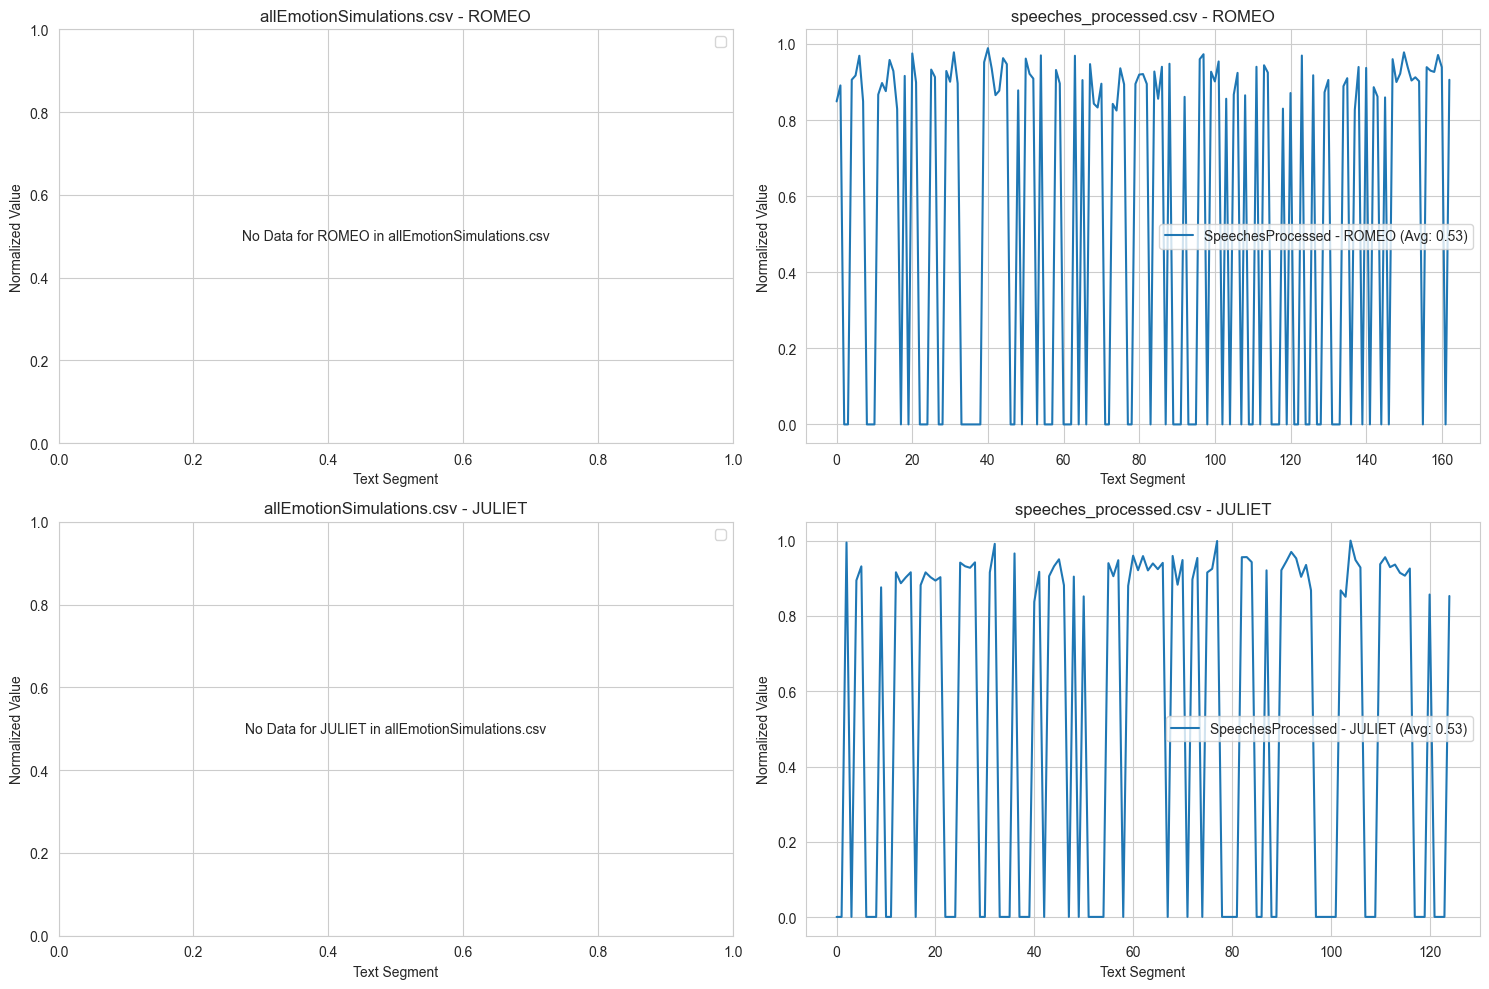

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import ast  # For safely evaluating strings as lists

# Function to normalize data
def normalize_data(data):
    # Ensure data is in a numeric format
    data = np.array(data, dtype=np.float64)

    # Handle NaNs
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    # Normalize data
    if max_val > min_val:
        normalized = 2 * ((data - min_val) / (max_val - min_val)) - 1
    else:
        normalized = -np.ones_like(data)

    return normalized

# Function to prepare data for plotting for df_emotion
def prepare_data_for_plotting_emotion(df, character):
    # Filter data for the character
    # check if df has column named 'time'
    if 'time' in df.columns:
        filtered_data = df[df['speaker'] == character]['simulation']  # Selecting dimension columns
    else:
        filtered_data = df[df['speaker'] == character]['simulation'].tolist()

    # Convert string representations to lists of numbers
    processed_data = []
    for data in filtered_data:
        if isinstance(data, str):
            try:
                data = ast.literal_eval(data)
            except Exception as e:
                print(f"Error occurred: {e}")
                continue  # Skip if the string cannot be converted
        if data:  # Check if the list is not empty
            processed_data.append(data)

    if not processed_data:
        return None, None

    # Normalize and calculate average values
    normalized_data = normalize_data(np.array(processed_data))
    avg_values = np.mean(normalized_data, axis=0)

    # Find the dimension with the highest average
    max_avg_dim_index = np.argmax(avg_values)
    max_avg_dim = avg_values[max_avg_dim_index]

    return normalized_data[:, max_avg_dim_index], max_avg_dim
def prepare_data_for_plotting_emotion(df, character):
    filtered_data = df[df['speaker'] == character]['simulation'].tolist()
    processed_data = []
    for data in filtered_data:
        if isinstance(data, str):
            try:
                data = ast.literal_eval(data)
            except Exception as e:
                print(f"Error occurred: {e}")
                continue
        if data:
            processed_data.append(data)

    if not processed_data:
        return None, None

    normalized_data = normalize_data(np.array(processed_data))
    avg_values = np.mean(normalized_data, axis=0)

    print(f"Normalized data shape: {normalized_data.shape}")
    print(f"Avg values length: {len(avg_values)}")

    max_avg_dim_index = np.argmax(avg_values)
    print(f"Max Avg Dim Index: {max_avg_dim_index}")

    try:
        max_avg_dim = avg_values[max_avg_dim_index]
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"Invalid index {max_avg_dim_index} for array of length {len(avg_values)}")
        return None, None

    return normalized_data[:, max_avg_dim_index], max_avg_dim

# Function to prepare data for plotting for df_speeches
def prepare_data_for_plotting_speeches(df, character):
    # Filter data for the character
    filtered_data = df[df['speaker'] == character].iloc[:, 3:].values  # Selecting dimension columns

    if filtered_data.size == 0:
        return None, None

    # Normalize and calculate average values
    normalized_data = normalize_data(filtered_data)
    avg_values = np.mean(normalized_data, axis=0)

    # Find the dimension with the highest average
    max_avg_dim_index = np.argmax(avg_values)
    max_avg_dim = avg_values[max_avg_dim_index]

    return normalized_data[:, max_avg_dim_index], max_avg_dim

# Main function to plot the highest average dimension for characters
def plot_highest_avg_dimension_for_characters(df_emotion, df_speeches, character_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 characters, 2 datasets
    axes = axes.flatten()  # Flatten for easy indexing

    for i, character in enumerate(character_names):
        logging.info(f"Processing {character}")
        # Emotion data from allEmotionSimulations.csv
        emotion_data, emotion_max_avg_dim = prepare_data_for_plotting_emotion(df_emotion, character)
        if emotion_data is not None:
            axes[2*i].plot(emotion_data, label=f"AllEmotionSimulations - {character} (Avg: {emotion_max_avg_dim:.2f})")
        else:
            axes[2*i].text(0.5, 0.5, f'No Data for {character} in allEmotionSimulations.csv', horizontalalignment='center', verticalalignment='center', transform=axes[2*i].transAxes)

        # Emotion data from speeches_processed.csv
        speeches_data, speeches_max_avg_dim = prepare_data_for_plotting_speeches(df_speeches, character)
        if speeches_data is not None:
            axes[2*i + 1].plot(speeches_data, label=f"SpeechesProcessed - {character} (Avg: {speeches_max_avg_dim:.2f})")
        else:
            axes[2*i + 1].text(0.5, 0.5, f'No Data for {character} in speeches_processed.csv', horizontalalignment='center', verticalalignment='center', transform=axes[2*i + 1].transAxes)

        # Set titles and labels for each subplot
        axes[2*i].set_title(f'allEmotionSimulations.csv - {character}')
        axes[2*i + 1].set_title(f'speeches_processed.csv - {character}')
        for ax in [axes[2*i], axes[2*i + 1]]:
            ax.set_xlabel('Text Segment')
            ax.set_ylabel('Normalized Value')
            ax.legend()

    plt.tight_layout()
    plt.show()

# Load your datasets
df_speeches = pd.read_csv('results/speeches_processed.csv')  # Replace with the path to your file

# Call the plotting function
character_names = ['ROMEO', 'JULIET']
plot_highest_avg_dimension_for_characters(df_emotion, df_speeches, character_names)

In [24]:
df_emotion = pd.read_pickle('results/allEmotionSimulations.pkl') # Replace with the path to your file
print(df_emotion.keys())
for key in list(df_emotion.keys())[:1]:
    print(f"Key: {key}, Value: {df_emotion[key]}")

dict_keys(['The Second Part of Henry the Sixth', 'As You Like It', 'Pericles, Prince of Tyre', 'The Third Part of Henry the Sixth', 'The First Part of Henry the Sixth', 'The Life of Timon of Athens', 'The Comedy of Errors', 'The Tragedy of Romeo and Juliet', 'The Taming of the Shrew', 'The Tragedy of Coriolanus', 'The Life and Death of King John', 'The Tragedy of Othello, the Moor of Venice', 'The Tragedy of Titus Andronicus', "A Midsummer Night's Dream", 'The Tragedy of Richard the Third', 'The Tempest', 'The Two Gentlemen of Verona', 'Cymbeline', 'The Merry Wives of Windsor', 'The Merchant of Venice', "All's Well That Ends Well", 'Much Ado about Nothing', 'The Tragedy of Macbeth', "The Winter's Tale", 'The Tragedy of Hamlet, Prince of Denmark', 'The Tragedy of King Lear', 'The History of Troilus and Cressida', 'The First Part of Henry the Fourth', 'The Tragedy of King Richard the Second', 'Twelfth Night, or What You Will', "Love's Labour's Lost", 'The Famous History of the Life of He